In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, Flatten
import os
import h5py
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy.stats.mstats import gmean

In [2]:
# Generates a randomized timeshift, outputs that timeshift and the corresponding angle
def timeshift_gen(D):
    """
    D - distance between elements
    """
    #Random angle that the signal is approaching at (-70 to 70)
    #Most phased arrays go -60 to 60 degrees, but we will train to go a little beyond that
    angle = np.random.uniform(-1,1)*60
    #print(angle)
    #angle = 45
    c = 3e8
    
    #Calculate the time difference between the two antenna elements
    angle_rad = np.radians(angle)
    timeshift = (np.sin(angle_rad)*D)/c
    
    return timeshift, angle


In [3]:
#Apply the timeshift to the signal
def apply_shift(signal, timeshift, fc, fs):
    # delta(t0) -> exp(-2j*omega*t0)
    # delta(t1) -> exp(-2j*omega*t1)
    # nyquist_component = sum signal[n] * exp(-2j*pi*1/2*n)
    #                   = sum signal[n] * exp(-j*pi*n)
    #                   = sum signal[n] * -1^n
    # nyquist_component of delta(t0) = exp(-j*pi*t0/ts)/2 + exp(j*pi*t0/ts)/2
    #                                = cos(pi*t0/ts)
    n = len(signal)
    assert n%2 == 0 
    signal_1_f = np.fft.fft(signal)
    signal_1_f = np.fft.fftshift(signal_1_f)
    
    signal_1_f_0 = signal_1_f[0]
    
    freqs = np.array(range(-n//2, n//2))/n * fs
    freqs = freqs + fc
    
    signal_1_f = signal_1_f*np.exp(-1j*2*np.pi*freqs*timeshift)
    signal_1_f[0] = signal_1_f_0 * np.cos(2*np.pi*fs/2*timeshift) * np.exp(-1j*2*np.pi*fc*timeshift)
    
    signal_1_f = np.fft.fftshift(signal_1_f)
    signal_1_t = np.fft.ifft(signal_1_f)
    #print(signal_1_f)
    
    return signal_1_t

In [ ]:
#This function takes in the data to be input into the NN and scales it to a range of (-1,1). Also Formats the data into a way 
#That is usable by the NN

# This function isn't used anymore since I have been using a correlation method
# to find the AoA as opposed to the phase differencing method.

"""

def fft_data(signal_0, signal_1, angles):
    
    n = len(signal_0[0])
    dataset = []
    labels = []
    temp_phase = []
    temp_amp = []

    temp_corr = []
    
    phase0 = []
    amp0 = []
    phase1 = []
    amp1 = []
    
    signal_0_f = np.fft.fft(signal_0); signal_0_f = np.fft.fftshift(signal_0_f)
    signal_1_f = np.fft.fft(signal_1); signal_1_f = np.fft.fftshift(signal_1_f)
    
    phase0 = np.angle(signal_0_f)
    amp0 = np.abs(signal_0_f)
    phase1 = np.angle(signal_1_f)
    amp1 = np.abs(signal_1_f)
    
    
    #for i in range(len(signal_0)):
    #    temp = signal.correlate(signal_0[i], signal_1[i], mode ='same', method = 'auto')#/np.sqrt(signal.correlate(signal_0[i], signal_0[i], mode ='same', method = 'auto')*signal.correlate(signal_1[i], signal_1[i], mode ='same', method = 'auto'))
    #    temp_corr.append(temp)
        
    #for i in range(len(temp_corr)):
    #    scaler = np.max(np.abs(temp_corr[i]))
    #    temp_corr[i] = temp_corr[i]/scaler
    
    
    #temp_phase = np.angle(temp_corr)
    #temp_amp = np.abs(temp_corr)
    
    #scaler = MinMaxScaler(feature_range=(-1,1))
    
    #temp_phase = scaler.fit_transform(temp_phase)
    #temp_amp = scaler.fit_transform(temp_amp)
    #temp1_phase = scaler.fit_transform(phase1)
    #temp1_amp = scaler.fit_transform(amp1)
    
    #for n in range(len(temp0_phase)):
    #    temp_phase.append(temp0_phase[n]/(np.max(np.abs(temp0_phase[n]))))
    #    temp_amp.append(temp0_amp[n]/(np.max(np.abs(temp0_amp[n]))))
    angles = np.radians(angles)
    angles_scaled = angles/(np.pi/2)
    
    
    #print(temp0_phase.shape)
    #print(temp0_amp.shape)
    #print(temp1_phase.shape)
    #print(temp1_amp.shape)
    
    #print(temp0_phase[0])
    
    plt.plot(np.unwrap(phase0[0] - phase1[0]))
    
    for i in range(len(phase0)):
        sigs = [phase0[i], phase1[i]]
        params = angles_scaled[i]
        dataset.append(sigs)
        labels.append(params)
        
    return dataset, labels
    """
    

In [4]:
# This function takes the signals data/labels, and seperates them into seperate NN inputs
# It will output the different datasets and lables.

def corr_data(signal_0, signal_1, angles, starts, stops, center, bandwidth):
    
    n = len(signal_0[0])
    dataset2 = []
    labels2 = []
    dataset = []
    dataset3 = []
    labels3 = []
    labels = []
    temp_real = []
    temp_imag = []

    temp_corr = []


    for i in range(len(signal_0)):
        temp = signal.correlate(signal_0[i], signal_1[i], mode ='same', method = 'auto')#/np.sqrt(signal.correlate(signal_0[i], signal_0[i], mode ='same', method = 'auto')*signal.correlate(signal_1[i], signal_1[i], mode ='same', method = 'auto'))
        temp_corr.append(temp)
        
    #for i in range(len(temp_corr)):
    #    scaler = np.max(np.abs(temp_corr[i]))
    #    temp_corr[i] = temp_corr[i]/scaler
    
    
    temp_real = np.real(temp_corr)
    temp_real = temp_real/100
    temp_imag = np.imag(temp_corr)
    temp_imag = temp_imag/(2*np.pi)
    
    #scaler = MinMaxScaler(feature_range=(-1,1))
    
    #temp_phase = scaler.fit_transform(temp_phase)
    #temp_amp = scaler.fit_transform(temp_amp)
    #temp1_phase = scaler.fit_transform(phase1)
    #temp1_amp = scaler.fit_transform(amp1)
    
    #for n in range(len(temp0_phase)):
    #    temp_phase.append(temp0_phase[n]/(np.max(np.abs(temp0_phase[n]))))
    #    temp_amp.append(temp0_amp[n]/(np.max(np.abs(temp0_amp[n]))))
    angles = np.radians(angles)
    angles_scaled = angles/(np.pi/2)
    
    signal_0_f = np.fft.fft(signal_0); #signal_0_f = np.fft.fftshift(signal_0_f)
    
    
    #print(temp0_phase.shape)
    #print(temp0_amp.shape)
    #print(temp1_phase.shape)
    #print(temp1_amp.shape)
    
    #print(temp0_phase[0])
    
    for i in range(len(temp_real)):
        sigs = [temp_real[i], temp_imag[i]]
        params = angles_scaled[i]
        params2 = [starts[i]/len(signal_0[0]), stops[i]/len(signal_0[0])]
        params3 = [center[i], bandwidth[i]]
        
        dataset.append(sigs)
        dataset2.append(signal_0[i])
        dataset3.append(np.abs(signal_0_f[i]))
        labels.append(params)
        labels2.append(params2)
        labels3.append(params3)
        
    return dataset, dataset2, dataset3, labels, labels2, labels3
    

In [5]:
#This function takes the two signals and applies noise
def add_noise(signal, noise):
    real_noise_0 = np.random.normal(0,noise, len(signal))
    imag_noise_0 = 1j*np.random.normal(0,noise, len(signal))
    signal_noise = signal + real_noise_0 + imag_noise_0

    return signal_noise

In [6]:
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices([], 'GPU')
#print("Num GPUs Available: ", len(physical_devices))

2022-03-09 12:41:39.634281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-09 12:41:39.663597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 12:41:39.663715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 208.91GiB/s
2022-03-09 12:41:39.663737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-09 12:41:39.667312: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-09 12:41:39.667350: I tensorflow/stream_executor/plat

In [7]:

with h5py.File("/data/signal_discovery_cnn/1024_Samples.h5", "r") as f:
    # List all groups
    items = f.keys()               #Checks what "folders" are within the file
    #print("Items in base: ", items)
    G1 = f.get('generated_data')   #Gets the contents of the generated data folder
    #print(G1.keys())               #Checks what datasets are within the folder
    
    #Gets the content of the dataset named 'signal_0' (Stored signals are in the time domain)
    #The rest of these lines also just read the data from the h5 file
    signal_0 = np.array(G1.get('dataset')); #signal_0 = signal_0[0:7500] 
    #signal_1 = np.array(G1.get('signal_1')); #signal_1 = signal_1[0:7500]
    starts = np.array(G1.get('starts')); #start = start[0:7500]
    stops = np.array(G1.get('stops')); #stop = stop[0:7500]
    center = np.array(G1.get('centers'))
    bandwidth = np.array(G1.get('bandwidths'))
    #angles = np.array(G1.get('angles')); #angles = angles[0:7500]
    print(len(signal_0))
    
    

30000


In [8]:
signal_1 = []
angles = []
D = 0.1
fc = 2e8
fs = 5e6
for i in range(len(signal_0)):
    timeshift, temp_angle = timeshift_gen(D)
    signal_1_t = apply_shift(signal_0[i], timeshift, fc, fs)
    signal_1.append(signal_1_t)
    angles.append(temp_angle)
    
signal_1 = np.array(signal_1)
angles = np.array(angles)

In [9]:
#noise = 0.05 #0.05 seems to be a good value for noise
for i in range(len(signal_0)):
    noise = np.random.uniform(0,0.1)
    signal_0[i] = add_noise(signal_0[i], noise)
    signal_1[i] = add_noise(signal_1[i], noise)

In [ ]:
# This cell just is used to verify the angles that I am generating make sense.

signal_0_f = np.fft.fft(signal_0[1]); signal_0_f = np.fft.fftshift(signal_0_f)
signal_1_f = np.fft.fft(signal_1[1]); signal_1_f = np.fft.fftshift(signal_1_f)

phase0 = np.angle(signal_0_f)
phase1 = np.angle(signal_1_f)

phasediff = np.unwrap(phase0-phase1)
plt.plot(phasediff)

n = len(signal_0_f)
c = 3e8

freqs = np.array(range(-n//2, n//2))/n * fs
freqs = freqs + fc

slope = np.polyfit(freqs, phasediff, 1)[0]/(2*np.pi)
print(slope)

calc_angle = math.asin((c*slope)/D)
calc_angle = calc_angle * 180/np.pi #Converts to degrees

print("Calc Angle: ", calc_angle)
print("Angle: ", angles[1])

In [10]:
# Pass the signals and the labels into the data prep function
dataset,dataset2,dataset3, labels, labels2, labels3 = corr_data(signal_0, signal_1, angles, starts, stops, center, bandwidth) #Scales the dataset and labels to be within (-1,1)  
#del sig_0_trimmed
#del sig_1_trimmed
#del signal_0
#del signal_1
#This section seperates the data into an 80/20 training vs testing split
angleX = dataset # list of all signals
timeX = dataset2
angleY = labels # list of labels
timeY = labels2
freqX = dataset3
freqY = labels3

#del dataset
#del labels

#print(allX)

In [11]:
#Convert the datasets to numpy arrays

angleX = np.array(angleX)
timeX = np.array(timeX)
angleY = np.array(angleY)
timeY = np.array(timeY)
freqX = np.array(freqX)
freqY = np.array(freqY)

In [12]:
# Shuffle the data

train_angleX = []; test_angleX = []
train_timeX = [];  test_timeX = []
train_angleY = []; test_angleY = []
train_timeY = []; test_timeY = []
train_freqX = []; test_freqX = []
train_freqY = []; test_freqY = []

N = len(angleX)
indexes = list(range(N))
np.random.shuffle(indexes)

M = int(N* 0.2) # 80/20 train/test split

for idx in indexes[0:M]:
    test_angleX.append(angleX[idx])
    test_timeX.append(timeX[idx])
    test_angleY.append(angleY[idx])
    test_timeY.append(timeY[idx])
    test_freqX.append(freqX[idx])
    test_freqY.append(freqY[idx])


for idx in indexes[M:]:
    train_timeX.append(timeX[idx])
    train_angleX.append(angleX[idx])
    train_angleY.append(angleY[idx])
    train_timeY.append(timeY[idx])
    train_freqX.append(freqX[idx])
    train_freqY.append(freqY[idx])

#del allX
#del allY

train_angleX = np.array(train_angleX)
train_timeX = np.array(train_timeX)
train_angleY = np.array(train_angleY)
train_timeY = np.array(train_timeY)
train_freqX = np.array(train_freqX)
train_freqY = np.array(train_freqY)

test_angleX = np.array(test_angleX)
test_timeX = np.array(test_timeX)
test_angleY = np.array(test_angleY)
test_timeY = np.array(test_timeY)
test_freqX = np.array(test_freqX)
test_freqY = np.array(test_freqY)

In [14]:

# Input of the AoA portion of the network
input1 = Input(shape=(2,1024))    #Input format is [real, imag] of correllated elements

layer1 = Dense(4096, activation='tanh')(input1)

layer2 = Dense(2048, activation='tanh')(layer1)

layer3 = Dense(1024, activation='tanh')(layer2)

angle_output = Flatten()(layer3)
angle_output = Dense(1, activation = 'tanh', name='Angle_Out')(angle_output)

#Input for the time portion of the network

input2 = Input(shape=(1024,1))

layer11 = Conv1D(filters=32, kernel_size = 3,activation="relu")(input2)
layer11 = MaxPooling1D(2)(layer11)

layer12 = Conv1D(filters=64, kernel_size = 3,activation="relu")(layer11)
layer12 = MaxPooling1D(2)(layer12)

layer13 = Conv1D(filters = 64, kernel_size = 3,activation="relu")(layer12)
layer13 = MaxPooling1D(2)(layer13)

layer14 = Conv1D(filters = 128, kernel_size = 3,activation="relu")(layer13)
layer14 = MaxPooling1D(2)(layer14)

layer15 = Conv1D(filters=256, kernel_size = 3,activation="relu")(layer14)
layer15 = MaxPooling1D(3)(layer15)

time_output = Flatten()(layer15)
time_output = Dense(2, activation='relu', name='Time_Out')(time_output)

# Input for the frequency portion of the network 

input3 = Input(shape=(1024,1))    #Test input_time, input_angle
# fully connected layer w/ 1 nodes
layer21 = Conv1D(filters=32, kernel_size = 3,activation="tanh")(input3)
layer21 = MaxPooling1D(2)(layer21)

layer22 = Conv1D(filters=64, kernel_size = 3,activation="tanh")(layer21)
layer22 = MaxPooling1D(2)(layer22)

layer23 = Conv1D(filters = 64, kernel_size = 3,activation="tanh")(layer22)
layer23 = MaxPooling1D(2)(layer23)

layer24 = Conv1D(filters = 128, kernel_size = 3,activation="tanh")(layer23)
layer24 = MaxPooling1D(2)(layer24)

layer25 = Conv1D(filters=256, kernel_size = 3,activation="tanh")(layer24)
layer25 = MaxPooling1D(3)(layer25)

output_freq = Flatten()(layer25)
output_freq = Dense(2, activation="tanh", name='Frequency_Out')(output_freq)

# set the input and output layers
model = Model(inputs=[input1, input2, input3], outputs=[angle_output, time_output, output_freq])
model.summary() # print layer info

#This is leftover code from the previous NN where I changed the learning rate, for now I just want to use
#a standard learning rate until I can get this network functioning.

 #tell tensorflow what optimizer/loss function
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.1,
#    decay_steps=3600,
#    decay_rate=0.5)

opt = keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(optimizer = opt,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])
      
# Train the model
history = model.fit([train_angleX, train_timeX, train_freqX], [train_angleY, train_timeY, train_freqY], epochs=100, batch_size=100,
          validation_data=([test_angleX, test_timeX, test_freqX], [test_angleY, test_timeY, test_freqY]))

training_loss = np.log10(history.history['loss'])
test_loss = np.log10(history.history ['val_loss'])

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.legend(["Training Loss","Test Loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss log10(MSE)')
plt.show()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1022, 32)     128         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 1022, 32)     128         input_6[0][0]                    
____________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
plt.plot(train_timeX[4])

Angle -- NN Output:  10.18671602010727 Actual Label:  6.04078655870393
Start -- CNN Output:  819.0069580078125 Actual Label:  814.0
Stop -- CNN Output:  984.8987426757812 Actual Label:  981.0


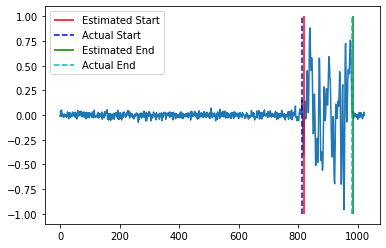

Center Frequency -- CNN Output:  0.03228853 Actual Label:  0.0423034
Bandwidth -- CNN Output:  0.16947374 Actual Label:  0.175982


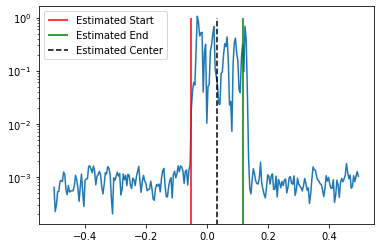


Angle -- NN Output:  55.0962370634079 Actual Label:  59.447851765469565
Start -- CNN Output:  741.9141845703125 Actual Label:  743.0
Stop -- CNN Output:  971.1318969726562 Actual Label:  983.0


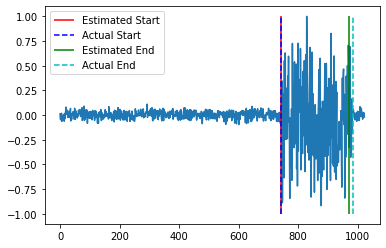

Center Frequency -- CNN Output:  -0.0024918283 Actual Label:  -0.0212616
Bandwidth -- CNN Output:  0.8221854 Actual Label:  0.8059692


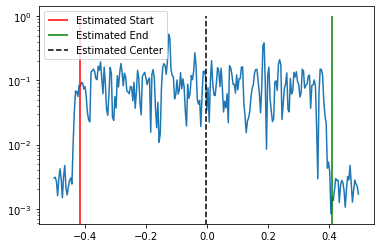


Angle -- NN Output:  -16.689888685941696 Actual Label:  -2.6636734678396223
Start -- CNN Output:  333.3789978027344 Actual Label:  352.0
Stop -- CNN Output:  976.8014526367188 Actual Label:  1014.0


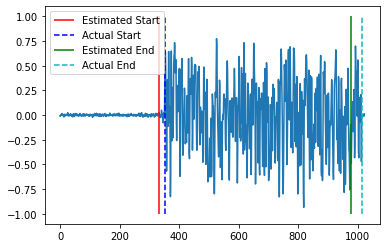

Center Frequency -- CNN Output:  -0.07702137 Actual Label:  -0.0795358
Bandwidth -- CNN Output:  0.33027297 Actual Label:  0.362015


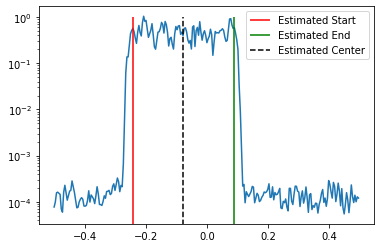


Angle -- NN Output:  58.8666719198227 Actual Label:  46.78823502684028
Start -- CNN Output:  304.5231018066406 Actual Label:  313.0
Stop -- CNN Output:  837.3208618164062 Actual Label:  841.0


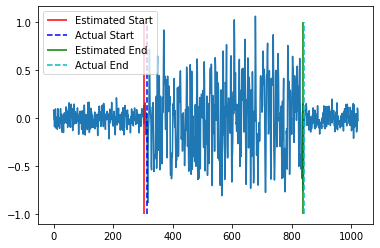

Center Frequency -- CNN Output:  -0.06733845 Actual Label:  -0.0878402
Bandwidth -- CNN Output:  0.44596338 Actual Label:  0.4216938


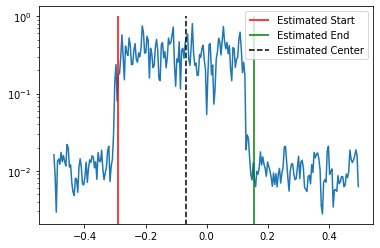


Angle -- NN Output:  -26.232570111751556 Actual Label:  -25.225027322100654
Start -- CNN Output:  261.33697509765625 Actual Label:  257.0
Stop -- CNN Output:  594.07763671875 Actual Label:  588.0


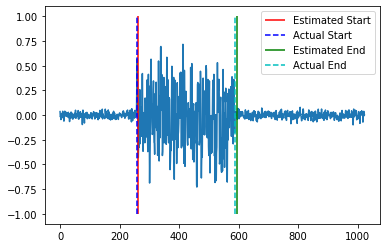

Center Frequency -- CNN Output:  0.039413672 Actual Label:  0.0492208
Bandwidth -- CNN Output:  0.5958224 Actual Label:  0.603114


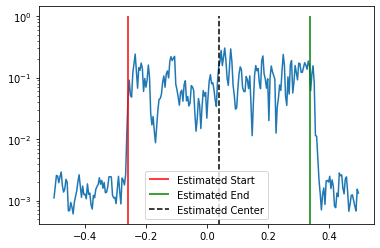


Angle -- NN Output:  -41.12545520067215 Actual Label:  -45.673220167076515
Start -- CNN Output:  812.7208251953125 Actual Label:  805.0
Stop -- CNN Output:  1009.1923828125 Actual Label:  1021.0


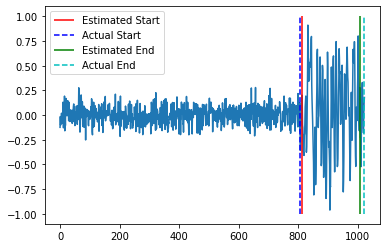

Center Frequency -- CNN Output:  0.04078161 Actual Label:  0.0274152
Bandwidth -- CNN Output:  0.2843641 Actual Label:  0.2969818


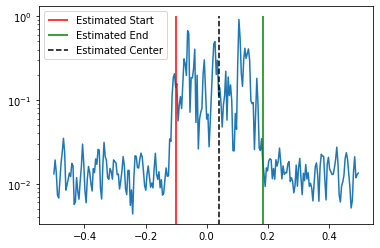


Angle -- NN Output:  -21.32204219698906 Actual Label:  -15.508264472561622
Start -- CNN Output:  524.2684936523438 Actual Label:  526.0
Stop -- CNN Output:  956.7335815429688 Actual Label:  955.0


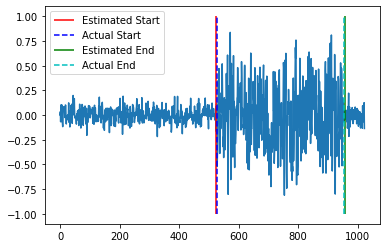

Center Frequency -- CNN Output:  0.04226412 Actual Label:  0.0432644
Bandwidth -- CNN Output:  0.7343286 Actual Label:  0.7383194


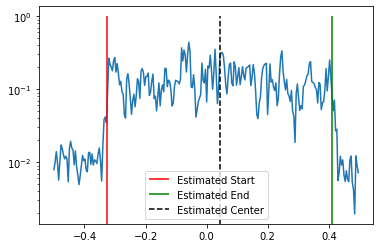


Angle -- NN Output:  38.134644627571106 Actual Label:  36.4043662075637
Start -- CNN Output:  783.9976806640625 Actual Label:  781.0
Stop -- CNN Output:  985.0387573242188 Actual Label:  977.0


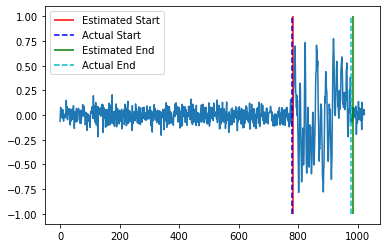

Center Frequency -- CNN Output:  0.020590218 Actual Label:  0.0297408
Bandwidth -- CNN Output:  0.21386601 Actual Label:  0.1926906


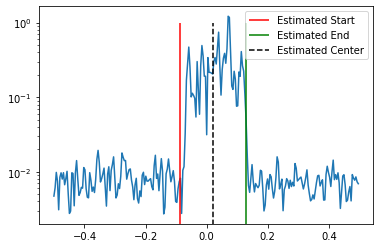


Angle -- NN Output:  -49.038843512535095 Actual Label:  -48.59307438503498
Start -- CNN Output:  466.30377197265625 Actual Label:  479.0
Stop -- CNN Output:  720.799560546875 Actual Label:  735.0


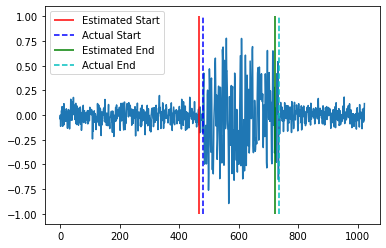

Center Frequency -- CNN Output:  0.075567104 Actual Label:  0.0780726
Bandwidth -- CNN Output:  0.49866188 Actual Label:  0.5024748


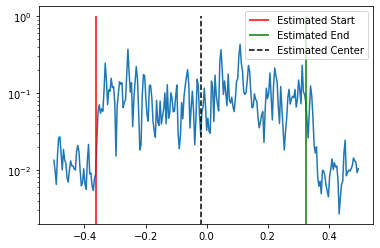


Angle -- NN Output:  -25.733290314674377 Actual Label:  -26.333750853943947
Start -- CNN Output:  741.8905029296875 Actual Label:  749.0
Stop -- CNN Output:  965.4149169921875 Actual Label:  979.0


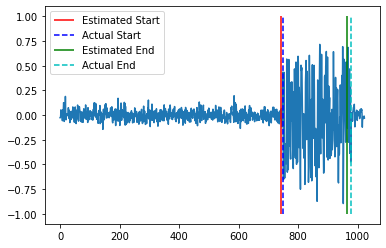

Center Frequency -- CNN Output:  -0.05183515 Actual Label:  -0.05535
Bandwidth -- CNN Output:  0.67131 Actual Label:  0.658036


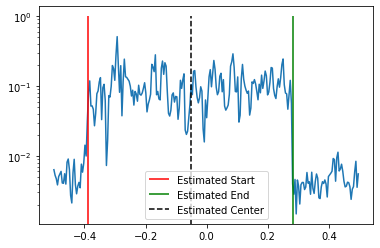


Angle -- NN Output:  0.10612975107505918 Actual Label:  9.005624774654414
Start -- CNN Output:  34.090240478515625 Actual Label:  34.0
Stop -- CNN Output:  831.9385375976562 Actual Label:  820.0


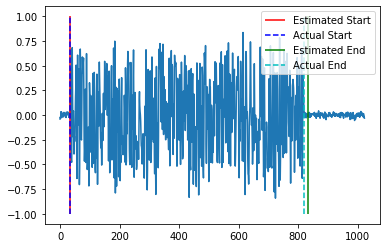

Center Frequency -- CNN Output:  -0.022206781 Actual Label:  0.0032538
Bandwidth -- CNN Output:  0.5812571 Actual Label:  0.5960308


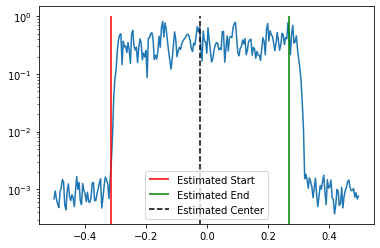


Angle -- NN Output:  -40.95361679792404 Actual Label:  -21.994320698680163
Start -- CNN Output:  152.74656677246094 Actual Label:  150.0
Stop -- CNN Output:  814.8461303710938 Actual Label:  806.0


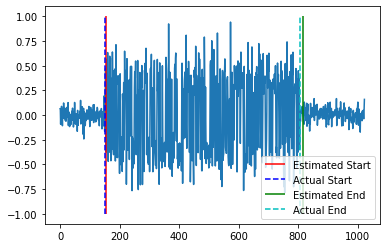

Center Frequency -- CNN Output:  0.0145527255 Actual Label:  -4.56e-05
Bandwidth -- CNN Output:  0.68396753 Actual Label:  0.6829666


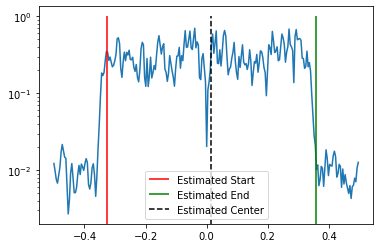


Angle -- NN Output:  28.77390146255493 Actual Label:  25.96412638438437
Start -- CNN Output:  734.8096923828125 Actual Label:  733.0
Stop -- CNN Output:  978.1696166992188 Actual Label:  975.0


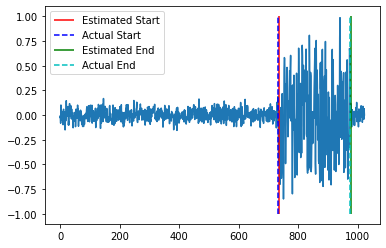

Center Frequency -- CNN Output:  0.05627939 Actual Label:  0.0471228
Bandwidth -- CNN Output:  0.7730917 Actual Label:  0.7414896


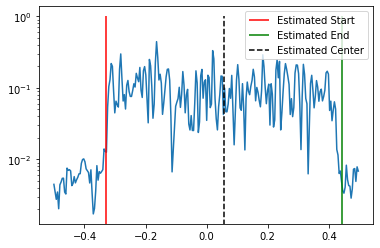


Angle -- NN Output:  -6.958037763834 Actual Label:  -9.862795153941576
Start -- CNN Output:  374.4315185546875 Actual Label:  386.0
Stop -- CNN Output:  614.1644897460938 Actual Label:  604.0


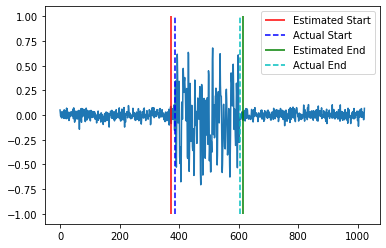

Center Frequency -- CNN Output:  0.035584237 Actual Label:  0.0288434
Bandwidth -- CNN Output:  0.42966753 Actual Label:  0.4303638


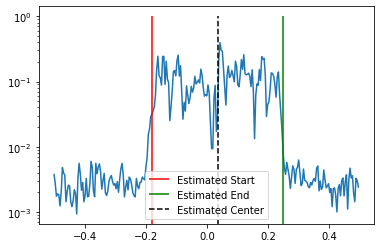

In [37]:
#This is just code to test the neural network to see how it is performing

import warnings
warnings.filterwarnings('ignore')

#load_model = keras.models.load_model("Angle_CNN_Test.h5")
#validatex = np.array(dataset)
#validatey = np.array(labels)
#load_model.evaluate(validatex, validatey, batch_size = 300)
results = model.predict([test_angleX, test_timeX, test_freqX])
#results = np.array(results)
#print(results.shape)

for i in range(20):
    #results = np.array(results)
    print("Angle -- NN Output: ", results[0][i,0]*180/np.pi*np.pi/2, "Actual Label: ", test_angleY[i]*180/np.pi*np.pi/2)
    print("Start -- CNN Output: ", results[1][i,0]*len(signal_0[0]), "Actual Label: ", test_timeY[i,0]*len(signal_0[0]))
    print("Stop -- CNN Output: ", results[1][i,1]*len(signal_0[0]), "Actual Label: ", test_timeY[i,1]*len(signal_0[0]))
    
    plt.plot(range(len(test_timeX[i])), test_timeX[i])
    plt.vlines(x=round(results[1][i,0]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    plt.vlines(x=round(test_timeY[i,0]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    plt.vlines(x=round(results[1][i,1]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    plt.vlines(x=round(test_timeY[i,1]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    plt.legend()
    plt.show()
    
    print("Center Frequency -- CNN Output: ", results[2][i,0], "Actual Label: ", test_freqY[i,0])
    print("Bandwidth -- CNN Output: ", results[2][i,1], "Actual Label: ", test_freqY[i,1])
    
    f, P = signal.welch(test_timeX[i])
    f = np.fft.fftshift(f)
    P = np.fft.fftshift(P)
    
    
    start =(results[2][i,0] - results[2][i,1]/2)
    end =  (results[2][i,0] + results[2][i,1]/2)
    act_start = (test_freqY[i,0] - test_timeY[i,1]/2)
    act_end = (test_freqY[i,0] + test_timeY[i,1]/2)
    
    center = results[2][i,0]
    act_center = test_freqY[i,0]
    
    plt.semilogy(f,P)
    plt.vlines(x=start, ymin = -.1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    #plt.vlines(x=act_start, ymin = -.1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    plt.vlines(x=end, ymin = -.1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    #plt.vlines(x=act_end, ymin = -.1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    plt.vlines(x=center, ymin = -.1, ymax = 1, colors = 'k', linestyles = 'dashed', label = 'Estimated Center')
    #plt.vlines(x=act_center, ymin = -.1, ymax = 1, colors = 'm', linestyles = 'dashed', label = 'Actual Center')
    plt.legend()
    plt.show()
    print()

#for i in range(20):
#    q = random.randint(0, len(testX))
#    print("CNN Output: ", results[q]*180/np.pi*np.pi/2, "Actual Label:", testY[q]*180/np.pi*np.pi/2)

In [ ]:
#model.save("All_In_One_NN.h5")

In [ ]:
lda = (3*10**8)/(2.5*10**9)

print(np.degrees(1.2*lda/.1))